In [22]:
import sys
import os
import pandas as pd
import numpy as np
import h5py
import pyBigWig
import sklearn.metrics
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, linregress
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

# allow custom utils to be visible (https://stackoverflow.com/a/23891673)
sys.path.append("..")

import chrombpnet.training.utils.data_utils as data_utils 
import chrombpnet.training.utils.metrics_utils as metrics_utils 

# display all outputs in a cell
get_ipython().ast_node_interactivity = 'all'
matplotlib.rc('pdf', fonttype=42)

# Overview

Here, we plot a the correlation between bias-factorized predicted log counts and observed log counts in peak regions for one model fold,
similar to the plot in the ChromBPNet QC output.

We can use the bias-factorized counts here because we expect the Tn5 bias to only affect _profiles_, not aggregated counts.

In [6]:
hdma_path = "../../../"
hdma_chrombpnet_path = hdma_path + "output/03-chrombpnet/"

# Load predicted counts

Read in the predicted counts:

In [7]:
preds_path = hdma_chrombpnet_path + "01-models/models/bias_Heart_c0_thresh0.4/Brain_c1/fold_0/evaluation/chrombpnet_predictions.h5"
preds_h5 = h5py.File(preds_path)

In [8]:
# investigate the contents
preds_h5.keys()
preds_h5['coords'].keys()
preds_h5['predictions'].keys()
preds_h5['coords']['coords_center'], preds_h5['coords']['coords_chrom']

<KeysViewHDF5 ['coords', 'predictions']>

<KeysViewHDF5 ['coords_center', 'coords_chrom', 'coords_peak']>

<KeysViewHDF5 ['logcounts', 'profs']>

(<HDF5 dataset "coords_center": shape (40767,), type "<i8">,
 <HDF5 dataset "coords_chrom": shape (40767,), type "|O">)

In [9]:
preds_h5['predictions']['logcounts'][0:5]
preds_h5['predictions']['logcounts'][-5:]

array([4.06688404, 4.14605284, 4.90732384, 5.02149391, 5.69477081])

array([7.16223764, 6.96864271, 7.26231623, 6.56804943, 6.20754671])

In [10]:
preds_h5['coords']['coords_chrom'][0], preds_h5['coords']['coords_center'][0]
preds_h5['coords']['coords_chrom'][1], preds_h5['coords']['coords_center'][1]
preds_h5['coords']['coords_chrom'][2], preds_h5['coords']['coords_center'][2]

(b'chr1', 9062)

(b'chr1', 9347)

(b'chr1', 179833)

In [11]:
y_pred_counts = preds_h5['predictions']['logcounts']

# Get observed counts

In [12]:
# make a dict given the test chromosomes per fold
test_chroms = {'fold_0': ['chr1', 'chr3', 'chr6'],
			   'fold_1': ['chr2', 'chr8', 'chr9', 'chr16'],
			   'fold_2': ['chr4', 'chr11', 'chr12', 'chr15', 'chrY'],
			   'fold_3': ['chr5', 'chr10', 'chr14', 'chr18', 'chr20', 'chr22'],
			   'fold_4': ['chr7', 'chr13', 'chr17', 'chr19', 'chr21', 'chrX']}
test_chroms['fold_0']

['chr1', 'chr3', 'chr6']

In [13]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

bed_path = os.path.join(hdma_chrombpnet_path, f"01-models/models/bias_Heart_c0_thresh0.4/Brain_c1/fold_0/auxiliary/filtered.peaks.bed")
pred_regions_df = pd.read_csv(bed_path, sep='\t', names=NARROWPEAK_SCHEMA)
pred_regions_df_filt = pred_regions_df[pred_regions_df['chr'].isin(test_chroms["fold_0"])]

bigwig_obs = hdma_chrombpnet_path + "00-inputs/bigwigs/Brain_c1_unstranded.bw"
outputlen = 1000
obs_bw = pyBigWig.open(bigwig_obs)
obs_data = data_utils.get_cts(pred_regions_df_filt,obs_bw,outputlen)
pred_regions_df_filt.shape, obs_data.shape

((40767, 10), (40767, 1000))

In [14]:
# calculating log summed counts per region
obs_counts_sum = np.log(np.sum(obs_data, axis=-1)+1)
y_pred_counts.shape, obs_counts_sum.shape, obs_counts_sum[0:5]

((40767,),
 (40767,),
 array([5.72031178, 5.72031178, 4.99721227, 4.70048037, 5.28826703]))

In [23]:
# calculate the correlations - which indeed now recapitulates what we see in the ChromBPNet evaluation
spearman_cor = spearmanr(obs_counts_sum, y_pred_counts)[0]
pearson_cor = pearsonr(obs_counts_sum, y_pred_counts)[0]
mse = ((obs_counts_sum - y_pred_counts)**2).mean(axis=0)
print(f"Spearman cor: {spearman_cor}")
print(f"Pearson cor: {pearson_cor}")
print(f"Mean squared error (MSE); {mse}")

Spearman cor: 0.7272529433734758
Pearson cor: 0.8039448050959739
Mean squared error (MSE); 0.36080195692819433


In [19]:
res = linregress(obs_counts_sum, y_pred_counts)
res
print(f"R-squared: {res.rvalue**2:.6f}")

LinregressResult(slope=0.7265423655141158, intercept=1.5281690093856, rvalue=0.8039448050959738, pvalue=0.0, stderr=0.0026619003103935885, intercept_stderr=0.016344463705286295)

R-squared: 0.646327


In [20]:
x = obs_counts_sum
y = y_pred_counts

# Plot correlation

Text(0, 0.5, 'Density')

Text(0.5, 0, 'Observed log(counts)')

Text(0, 0.5, 'Predicted log(counts)')

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

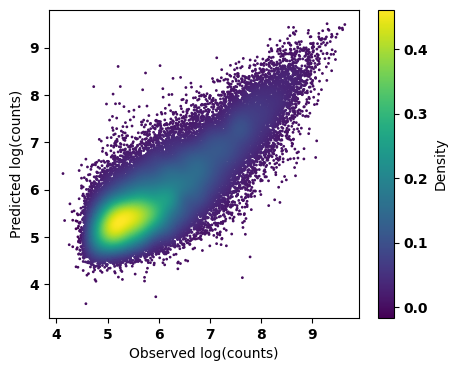

In [21]:
bins = 20
bad_indices=np.where(np.isnan(x))+np.where(np.isnan(y))
x=x[~np.isin(np.arange(x.size),bad_indices)]
y=y[~np.isin(np.arange(y.size),bad_indices)]

fig, ax = plt.subplots(figsize = (5, 4))
data, x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

#To be sure to plot all data
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax.scatter( x, y, c=z ,s = 1)

norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
cbar.ax.set_ylabel('Density')
plt.xlabel("Observed log(counts)")
plt.ylabel("Predicted log(counts)")
plt.savefig(hdma_path + "figures/03-chrombpnet/01-models/03b/Brain_c1_fold0_correlation.pdf");
plt.show()